**Stress Prediction [XGBoost | Optuna | SHAP]**

In [37]:
# pip install kagglehub[pandas-datasets] matplotlib nbformat plotly optuna shap xgboost

In [38]:
# pip install --upgrade jupyter ipywidgets

In [39]:
# @title
from IPython.display import display, HTML

pretty_header = """
<div style="
    margin-top: 40px;
    padding: 20px 10px;
    text-align: center;
    font-family: 'Segoe UI', sans-serif;
    color: #2c3e50;
">

    <h1 style="
        font-size: 28px;
        margin-bottom: 10px;
        background: linear-gradient(90deg, #1d70b8, #00a8e8);
        -webkit-background-clip: text;
        -webkit-text-fill-color: transparent;
        font-weight: 700;
    ">
        Uczenie maszynowe w Pythonie - Praca zaliczeniowa
    </h1>

    <h2 style="
        font-size: 20px;
        font-weight: 400;
        margin-top: 0;
        color: #555;
    ">
        Kierunek: Sztuczna Inteligencja i Automatyzacja Procesów Biznesowych w ujęciu technicznym
    </h2>

    <p style="
        font-size: 16px;
        margin-top: 15px;
    ">
        Projekt słuchaczy studiów podyplomowych
    </p>

    <p style="
        font-size: 16px;
        font-style: italic;
        margin-bottom: 0;
    ">
        Autorstwa:
    </p>
    <p style="font-size: 16px; font-weight: 500;">
        Krzysztof Lachs, Patryk Sowiński
    </p>
</div>
"""

display(HTML(pretty_header))

<h1 style="text-align: center;">Spis Treści</h1>

<div style="display: flex; justify-content: center;">
  <div style="text-align: left; background-color: #f9f9f9; padding: 20px 30px; border-radius: 10px; border: 1px solid #ddd; width: fit-content; font-size: 16px; line-height: 1.8;">

<ol>
  <li><a href="#wprowadzenie">Wprowadzenie</a></li>
  <li><a href="#wczytywanie-danych">Wczytywanie danych</a></li>
  <li><a href="#feature-engineering-/-eda">Feature Engineering / EDA</a></li>
  <li><a href="#modelowanie">Modelowanie</a></li>
  <li><a href="#optymalizacja-hiperparametrów">Optymalizacja hiperparametrów</a></li>
  <li><a href="#interpretacja-rezultatów">Interptretacja rezultatów</a></li>
</ol>

  </div>
</div>

<p style="text-align: center; font-size: 14px; color: gray;">⬆️ Kliknij linki, aby przejść do wybranej sekcji</p>

## Wprowadzenie

> **Temat projektu:**
> Model predykcyjny dotyczących prognozy poziomu stresu z wykorzystaniem raportu **Stress Level Prediction** oraz danych dotyczących metryk snu i stylu życia **Sleep Health and Lifestyle Dataset** dostępnych na platformie [Kaggle](https://www.kaggle.com)

<p align="center">
  <img src="Sleep_Health_and_Lifestyle_Dataset.png" width="450"/>
</p>

-------------------------------------------------------------------------------------------------------------------------------------------

## Wczytywanie danych
Wczytujemy dataset ze stress level prediction (KaggleHub), wyświetlamy pierwsze obserwacje oraz upewniamy się, że kolumny są poprawne.

In [40]:
import kagglehub
import numpy as np
import optuna
import pandas as pd
import plotly
import shap
from kagglehub import KaggleDatasetAdapter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from xgboost import XGBClassifier

In [73]:
file_path = "stress_detection_data.csv"

df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "shijo96john/stress-level-prediction",
  file_path,
)

pd.set_option('display.max_columns', None)


-------------------------------------------------------------------------------------------------------------------------------------------

<h1 style="text-align: center;">Koniec rozdziału: Wczytywanie danych</h1>

<div style="display: flex; justify-content: center;">
  <div style="text-align: left; background-color: #f9f9f9; padding: 20px 30px; border-radius: 10px; border: 1px solid #ddd; width: fit-content; font-size: 16px; line-height: 1.8;">

<ol>
  <li><a href="#wprowadzenie">Wprowadzenie</a></li>
  <li><a href="#wczytywanie-danych">Wczytywanie danych</a></li>
  <li><a href="#feature-engineering-/-eda">Feature Engineering / EDA</a></li>
  <li><a href="#modelowanie">Modelowanie</a></li>
  <li><a href="#optymalizacja-hiperparametrów">Optymalizacja hiperparametrów</a></li>
  <li><a href="#interpretacja-rezultatów">Interptretacja rezultatów</a></li>
</ol>

  </div>
</div>

<p style="text-align: center; font-size: 14px; color: gray;">⬆️ Kliknij linki, aby przejść do wybranej sekcji</p>

-------------------------------------------------------------------------------------------------------------------------------------------

## Feature Engineering / EDA

In [72]:
df.head()

,Age,Gender,Occupation,Marital_Status,Sleep_Duration,Sleep_Quality,Physical_Activity,Screen_Time,Caffeine_Intake,Alcohol_Intake,Smoking_Habit,Work_Hours,Travel_Time,Social_Interactions,Meditation_Practice,Exercise_Type,Blood_Pressure,Cholesterol_Level,Blood_Sugar_Level,Stress_Detection,Bed_Time_sin,Bed_Time_cos,Wake_Up_Time_sin,Wake_Up_Time_cos
0,30,Male,Software Engineer,Single,7.0,4.0,2.0,4.0,1,0,No,8,1.0,5,Yes,Cardio,120,180,90,0,0.500000,-0.866025,0.965926,-2.588190e-01
1,35,Female,Marketing Manager,Married,6.0,3.0,1.0,3.0,0,1,No,9,2.0,3,No,Yoga,110,160,80,1,0.258819,-0.965926,1.000000,6.123234e-17
2,40,Male,Data Scientist,Divorced,7.0,4.0,2.0,4.0,1,0,No,8,1.0,5,Yes,Strength Training,130,200,100,2,0.500000,-0.866025,0.965926,-2.588190e-01
3,35,Male,Software Engineer,Single,7.0,4.0,2.0,4.0,1,0,No,8,1.0,5,Yes,Cardio,120,180,90,0,0.500000,-0.866025,0.965926,-2.588190e-01
4,29,Female,Teacher,Single,8.0,5.0,3.0,2.0,1,0,No,7,1.0,4,Yes,Yoga,110,180,90,0,0.382683,-0.923880,0.991445,-1.305262e-01


In [42]:
df.isnull().sum()

Age                    0
Gender                 0
Occupation             0
Marital_Status         0
Sleep_Duration         0
Sleep_Quality          0
Wake_Up_Time           0
Bed_Time               0
Physical_Activity      0
Screen_Time            0
Caffeine_Intake        0
Alcohol_Intake         0
Smoking_Habit          0
Work_Hours             0
Travel_Time            0
Social_Interactions    0
Meditation_Practice    0
Exercise_Type          0
Blood_Pressure         0
Cholesterol_Level      0
Blood_Sugar_Level      0
Stress_Detection       0
dtype: int64

In [43]:
df.describe()

,Age,Sleep_Duration,Sleep_Quality,Physical_Activity,Screen_Time,Caffeine_Intake,Alcohol_Intake,Work_Hours,Travel_Time,Social_Interactions,Blood_Pressure,Cholesterol_Level,Blood_Sugar_Level
count,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000
mean,38.887451,6.338422,3.848124,2.979301,4.105433,1.818887,0.888745,8.258732,2.858344,3.196636,137.943079,220.834411,111.765847
std,7.686642,0.733584,0.545459,0.797234,0.812513,0.838396,0.673741,1.064168,1.083758,0.856332,13.122060,19.322622,12.533097
min,18.000000,3.500000,2.000000,1.000000,2.000000,0.000000,0.000000,6.000000,0.500000,1.000000,110.000000,150.000000,80.000000
25%,33.000000,6.000000,3.600000,2.000000,4.000000,1.000000,0.000000,8.000000,2.000000,3.000000,130.000000,210.000000,105.000000
50%,39.000000,6.300000,3.900000,3.000000,4.000000,2.000000,1.000000,8.000000,3.000000,3.000000,140.000000,220.000000,115.000000
75%,45.000000,7.000000,4.000000,4.000000,5.000000,2.000000,1.000000,9.000000,4.000000,4.000000,150.000000,230.000000,120.000000
max,60.000000,8.000000,5.000000,5.000000,8.000000,4.000000,2.000000,14.000000,5.000000,5.000000,170.000000,290.000000,150.000000


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 773 entries, 0 to 772
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  773 non-null    int64  
 1   Gender               773 non-null    object 
 2   Occupation           773 non-null    object 
 3   Marital_Status       773 non-null    object 
 4   Sleep_Duration       773 non-null    float64
 5   Sleep_Quality        773 non-null    float64
 6   Wake_Up_Time         773 non-null    object 
 7   Bed_Time             773 non-null    object 
 8   Physical_Activity    773 non-null    float64
 9   Screen_Time          773 non-null    float64
 10  Caffeine_Intake      773 non-null    int64  
 11  Alcohol_Intake       773 non-null    int64  
 12  Smoking_Habit        773 non-null    object 
 13  Work_Hours           773 non-null    int64  
 14  Travel_Time          773 non-null    float64
 15  Social_Interactions  773 non-null    int

In [45]:
STRESS_LEVEL_TO_LABEL = {
    'Low': 0,
    'Medium': 1,
    'High': 2
}
LABEL_TO_STRESS_LEVEL = {v: k for k, v in STRESS_LEVEL_TO_LABEL.items()}

df['Stress_Detection'] = df['Stress_Detection'].map(STRESS_LEVEL_TO_LABEL)

In [46]:
def time_to_float(time_str):
    time_str = time_str.replace("AM", "").replace("PM", "").strip()
    hours, minutes = map(int, time_str.split(":"))
    return hours + minutes/60

df["Bed_Time"] = df["Bed_Time"].astype(str)
df["Wake_Up_Time"] = df["Wake_Up_Time"].astype(str)
df["Bed_Time_float"] = df["Bed_Time"].apply(time_to_float)
df["Wake_Up_Time_float"] = df["Wake_Up_Time"].apply(time_to_float)
df["Bed_Time_sin"] = np.sin(2 * np.pi * df["Bed_Time_float"] / 24)
df["Bed_Time_cos"] = np.cos(2 * np.pi * df["Bed_Time_float"] / 24)
df["Wake_Up_Time_sin"] = np.sin(2 * np.pi * df["Wake_Up_Time_float"] / 24)
df["Wake_Up_Time_cos"] = np.cos(2 * np.pi * df["Wake_Up_Time_float"] / 24)

columns_to_drop = ["Bed_Time", "Wake_Up_Time", "Bed_Time_float", "Wake_Up_Time_float"]
df = df.drop(columns=columns_to_drop)

In [47]:
df.head()

,Age,Gender,Occupation,Marital_Status,Sleep_Duration,Sleep_Quality,Physical_Activity,Screen_Time,Caffeine_Intake,Alcohol_Intake,Smoking_Habit,Work_Hours,Travel_Time,Social_Interactions,Meditation_Practice,Exercise_Type,Blood_Pressure,Cholesterol_Level,Blood_Sugar_Level,Stress_Detection,Bed_Time_sin,Bed_Time_cos,Wake_Up_Time_sin,Wake_Up_Time_cos
0,30,Male,Software Engineer,Single,7.0,4.0,2.0,4.0,1,0,No,8,1.0,5,Yes,Cardio,120,180,90,0,0.500000,-0.866025,0.965926,-2.588190e-01
1,35,Female,Marketing Manager,Married,6.0,3.0,1.0,3.0,0,1,No,9,2.0,3,No,Yoga,110,160,80,1,0.258819,-0.965926,1.000000,6.123234e-17
2,40,Male,Data Scientist,Divorced,7.0,4.0,2.0,4.0,1,0,No,8,1.0,5,Yes,Strength Training,130,200,100,2,0.500000,-0.866025,0.965926,-2.588190e-01
3,35,Male,Software Engineer,Single,7.0,4.0,2.0,4.0,1,0,No,8,1.0,5,Yes,Cardio,120,180,90,0,0.500000,-0.866025,0.965926,-2.588190e-01
4,29,Female,Teacher,Single,8.0,5.0,3.0,2.0,1,0,No,7,1.0,4,Yes,Yoga,110,180,90,0,0.382683,-0.923880,0.991445,-1.305262e-01


In [48]:
categorical_cols = [col for col in df.select_dtypes(include=['object']).columns]
print(categorical_cols)

for col in categorical_cols:
    df[col] = df[col].astype('category')

['Gender', 'Occupation', 'Marital_Status', 'Smoking_Habit', 'Meditation_Practice', 'Exercise_Type']


In [63]:
# TODO: Detect outliers

# Zbieramy tylko kolumny numeryczne (bez targetu)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != "Stress_Detection"]

outlier_report = {}

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    outlier_report[col] = len(outliers)

# Wyświetlanie raportu
print("\n Wynik rapotru dotyczącego Outlier'ów")
for col, count in outlier_report.items():
    print(f"{col}: {count} outliers")



 Wynik rapotru dotyczącego Outlier'ów
Age: 0 outliers
Sleep_Duration: 28 outliers
Sleep_Quality: 83 outliers
Physical_Activity: 0 outliers
Screen_Time: 12 outliers
Caffeine_Intake: 2 outliers
Alcohol_Intake: 0 outliers
Work_Hours: 30 outliers
Travel_Time: 0 outliers
Social_Interactions: 1 outliers
Blood_Pressure: 0 outliers
Cholesterol_Level: 39 outliers
Blood_Sugar_Level: 19 outliers
Bed_Time_sin: 0 outliers
Bed_Time_cos: 0 outliers
Wake_Up_Time_sin: 55 outliers
Wake_Up_Time_cos: 0 outliers



CLASS BALANCE
Counts:
Stress_Detection
1    310
2    301
0    162
Name: count, dtype: int64

Percentage:
Stress_Detection
1    40.10%
2    38.94%
0    20.96%
Name: proportion, dtype: object


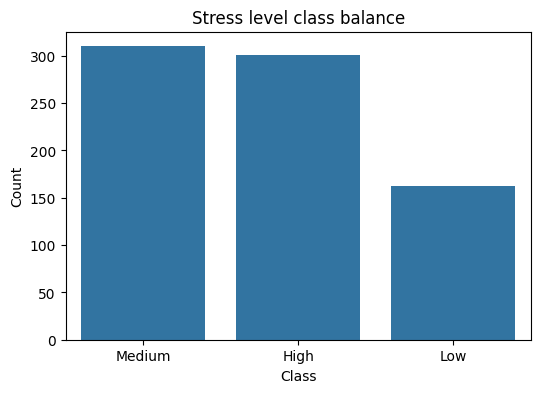

In [51]:

# TODO: Check class balance

import seaborn as sns

class_counts = df["Stress_Detection"].value_counts()
class_percent = df["Stress_Detection"].value_counts(normalize=True) * 100

print("\nCLASS BALANCE")
print("Counts:")
print(class_counts)
print("\nPercentage:")
print(class_percent.map(lambda x: f"{x:.2f}%"))

plt.figure(figsize=(6,4))
sns.barplot(
    x=class_counts.index.map(lambda i: LABEL_TO_STRESS_LEVEL[i]),
    y=class_counts.values
)
plt.title("Stress level class balance")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

-------------------------------------------------------------------------------------------------------------------------------------------

<h1 style="text-align: center;">Koniec rozdziału: Wczytywanie danych</h1>

<div style="display: flex; justify-content: center;">
  <div style="text-align: left; background-color: #f9f9f9; padding: 20px 30px; border-radius: 10px; border: 1px solid #ddd; width: fit-content; font-size: 16px; line-height: 1.8;">

<ol>
  <li><a href="#wprowadzenie">Wprowadzenie</a></li>
  <li><a href="#wczytywanie-danych">Wczytywanie danych</a></li>
  <li><a href="#feature-engineering-/-eda">Feature Engineering / EDA</a></li>
  <li><a href="#modelowanie">Modelowanie</a></li>
  <li><a href="#optymalizacja-hiperparametrów">Optymalizacja hiperparametrów</a></li>
  <li><a href="#interpretacja-rezultatów">Interptretacja rezultatów</a></li>
</ol>

  </div>
</div>

<p style="text-align: center; font-size: 14px; color: gray;">⬆️ Kliknij linki, aby przejść do wybranej sekcji</p>

-------------------------------------------------------------------------------------------------------------------------------------------

## Modelowanie

W tej części projektu budujemy pierwszy, bazowy model do przewidywania poziomu stresu na podstawie cech związanych ze stylem życia, snem, aktywnością i informacjami demograficznymi.
Po wcześniejszym przygotowaniu danych (czyszczenie, inżynieria cech, kodowanie kategorii) przechodzimy do:
- wydzielenia danych treningowych i testowych,

- zbudowania klasyfikatora XGBoost,

- przetrenowania go na danych,

- oceny jakości modelu przy użyciu metryki accuracy.

Ten etap ma na celu zbudowanie baseline modelu (modelu referencyjnego), który później będziemy ulepszać przy użyciu Optuny, SHAP oraz bardziej zaawansowanej inżynierii cech.

In [52]:
target = 'Stress_Detection'
X = df.drop(columns=[target])
y = df[target]

seed = 42
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed) 

model = XGBClassifier(enable_categorical=True) 
model.fit(X_train, y_train)

print(model)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)
Accuracy: 71.48%


-------------------------------------------------------------------------------------------------------------------------------------------

<h1 style="text-align: center;">Koniec rozdziału: Modelowanie</h1>

<div style="display: flex; justify-content: center;">
  <div style="text-align: left; background-color: #f9f9f9; padding: 20px 30px; border-radius: 10px; border: 1px solid #ddd; width: fit-content; font-size: 16px; line-height: 1.8;">

<ol>
  <li><a href="#wprowadzenie">Wprowadzenie</a></li>
  <li><a href="#wczytywanie-danych">Wczytywanie danych</a></li>
  <li><a href="#feature-engineering-/-eda">Feature Engineering / EDA</a></li>
  <li><a href="#modelowanie">Modelowanie</a></li>
  <li><a href="#optymalizacja-hiperparametrów">Optymalizacja hiperparametrów</a></li>
  <li><a href="#interpretacja-rezultatów">Interptretacja rezultatów</a></li>
</ol>

  </div>
</div>

<p style="text-align: center; font-size: 14px; color: gray;">⬆️ Kliknij linki, aby przejść do wybranej sekcji</p>

-------------------------------------------------------------------------------------------------------------------------------------------

## Optymalizacja hiperparametrów

W tym fragmencie kodu wykorzystujemy bibliotekę Optuna do automatycznej optymalizacji hiperparametrów modelu XGBoost. Zamiast ręcznie dobierać wartości takie jak max_depth, learning_rate czy n_estimators, Optuna sama przeszukuje przestrzeń parametrów i wybiera kombinacje dające najlepszy wynik.
Do oceny każdej konfiguracji używamy walidacji krzyżowej (StratifiedKFold), aby uzyskać stabilny, wiarygodny wynik niezależny od pojedynczego splitu danych.

In [53]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),  # default: 100 
        'max_depth': trial.suggest_int('max_depth', 3, 10),  # default: 3
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),  # default: 1
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),  # default: 0.1
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # default: 1
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # default: 1
        'gamma': trial.suggest_float('gamma', 0, 5),  # default: 0
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),  # default: 0
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),  # default: 1
        'enable_categorical': True
    }
    
    clf = XGBClassifier(**param)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # TODO: Memorize the reason behind using StratifiedKFold
    return cross_val_score(clf, X, y, n_jobs=-1, cv=skf).mean()


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=400)

trial = study.best_trial

print('Best Accuracy: {:.2f}%'.format(trial.value * 100))
print("Best hyperparameters: {}".format(trial.params))

[I 2025-11-25 20:48:03,650] A new study created in memory with name: no-name-1d7a7330-a4db-4e03-95cb-296d5d3429df


[I 2025-11-25 20:48:19,981] Trial 0 finished with value: 0.6779304566401341 and parameters: {'n_estimators': 230, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.22008545897350998, 'subsample': 0.5523550937900907, 'colsample_bytree': 0.9903765937001798, 'gamma': 0.6195757864106766, 'reg_alpha': 1.9262339234692083, 'reg_lambda': 9.14365512505668}. Best is trial 0 with value: 0.6779304566401341.
[I 2025-11-25 20:48:22,503] Trial 1 finished with value: 0.6779136992040218 and parameters: {'n_estimators': 306, 'max_depth': 7, 'min_child_weight': 3, 'learning_rate': 0.026528505466398362, 'subsample': 0.698430414724533, 'colsample_bytree': 0.5869030211910471, 'gamma': 1.5680523121236938, 'reg_alpha': 0.19589300365914442, 'reg_lambda': 3.0892106748886086}. Best is trial 0 with value: 0.6779304566401341.
[I 2025-11-25 20:48:24,891] Trial 2 finished with value: 0.6326267281105992 and parameters: {'n_estimators': 100, 'max_depth': 8, 'min_child_weight': 1, 'learning_rate': 0.04666075849

Best Accuracy: 73.22%
Best hyperparameters: {'n_estimators': 479, 'max_depth': 10, 'min_child_weight': 1, 'learning_rate': 0.05979759012516737, 'subsample': 0.7853628154604396, 'colsample_bytree': 0.6863709008469194, 'gamma': 0.013220064453084768, 'reg_alpha': 1.1421976672273646, 'reg_lambda': 4.370660900339126}


In [69]:
# TODO: Choose one/two plots to display

optuna.visualization.plot_optimization_history(study)
#optuna.visualization.plot_slice(study)
#optuna.visualization.plot_parallel_coordinate(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'markers',
              'name': 'Objective Value',
              'type': 'scatter',
              'x': [0, 1, 2, ..., 397, 398, 399],
              'y': [0.6779304566401341, 0.6779136992040218, 0.6326267281105992,
                    ..., 0.7128110599078342, 0.7153833263510683,
                    0.7231839128613322]},
             {'mode': 'lines',
              'name': 'Best Value',
              'type': 'scatter',
              'x': [0, 1, 2, ..., 397, 398, 399],
              'y': [0.6779304566401341, 0.6779304566401341, 0.6779304566401341,
                    ..., 0.7322413070800168, 0.7322413070800168,
                    0.7322413070800168]},
             {'marker': {'color': '#cccccc'},
              'mode': 'markers',
              'name': 'Infeasible Trial',
              'showlegend': False,
              'type': 'scatter',
              'x': [],
              'y': []}],
    'layout': {'template': '...',
               'title': {'text': 'Optimization History Plot'},
               'xaxis': {'title': {'text': 'Trial'}},
               'yaxis': {'title': {'text': 'Objective Value'}}}
})

Po zakończeniu procesu strojenia hiperparametrów za pomocą Optuna, otrzymujemy zestaw najlepszych parametrów (trial.best_params). Kolejnym krokiem jest wytrenowanie finalnego modelu XGBoost z tymi optymalnymi ustawieniami i sprawdzenie, jak poradzi sobie na danych testowych, czyli takich, których model wcześniej nie widział. Ten etap pozwala ocenić, czy optymalizacja rzeczywiście zwiększyła jakość predykcji.

In [61]:
# TODO: Train the model with best hyperparameters

best_params = trial.params
best_params['enable_categorical'] = True

best_model = XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

y_pred_best = best_model.predict(X_test)
acc_best = accuracy_score(y_test, y_pred_best)

print(f"Test accuracy with best hyperparameters: {acc_best * 100:.2f}%")


Test accuracy with best hyperparameters: 71.09%


-------------------------------------------------------------------------------------------------------------------------------------------

<h1 style="text-align: center;">Koniec rozdziału: Optymalizacja hiperparametrów</h1>

<div style="display: flex; justify-content: center;">
  <div style="text-align: left; background-color: #f9f9f9; padding: 20px 30px; border-radius: 10px; border: 1px solid #ddd; width: fit-content; font-size: 16px; line-height: 1.8;">

<ol>
  <li><a href="#wprowadzenie">Wprowadzenie</a></li>
  <li><a href="#wczytywanie-danych">Wczytywanie danych</a></li>
  <li><a href="#feature-engineering-/-eda">Feature Engineering / EDA</a></li>
  <li><a href="#modelowanie">Modelowanie</a></li>
  <li><a href="#optymalizacja-hiperparametrów">Optymalizacja hiperparametrów</a></li>
  <li><a href="#interpretacja-rezultatów">Interptretacja rezultatów</a></li>
</ol>

  </div>
</div>

<p style="text-align: center; font-size: 14px; color: gray;">⬆️ Kliknij linki, aby przejść do wybranej sekcji</p>

-------------------------------------------------------------------------------------------------------------------------------------------

## Interpretacja rezultatów

Biblioteka SHAP (SHapley Additive exPlanations) pozwala obliczyć, które cechy mają największy wpływ na decyzje modelu. Dzięki temu możemy ustalić m.in. jakie elementy stylu życia najbardziej wpływają na poziom stresu.

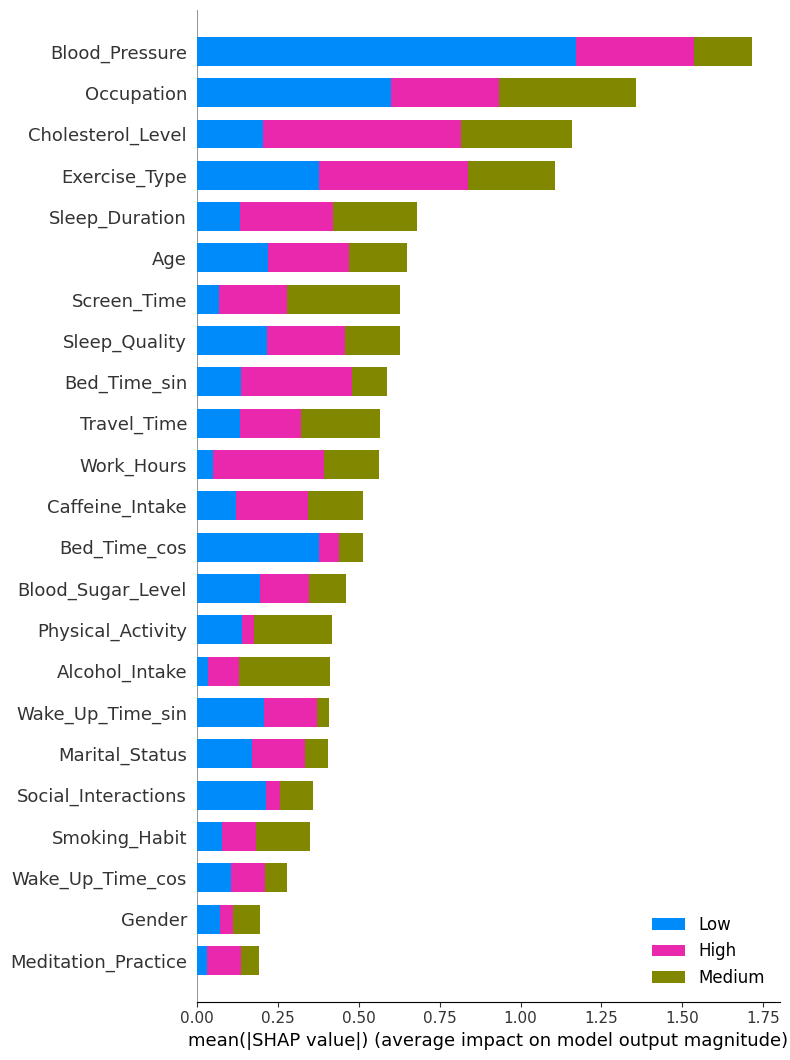

In [56]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=50,
                  class_names=[LABEL_TO_STRESS_LEVEL[i] for i in range(len(LABEL_TO_STRESS_LEVEL))]
                  )  # TODO: Preetify the plot and class names display order / change the plot type

In [70]:
# TODO: Choose one/two plots to display

optuna.visualization.plot_optimization_history(study)
# optuna.visualization.plot_slice(study)
# optuna.visualization.plot_parallel_coordinate(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'markers',
              'name': 'Objective Value',
              'type': 'scatter',
              'x': [0, 1, 2, ..., 397, 398, 399],
              'y': [0.6779304566401341, 0.6779136992040218, 0.6326267281105992,
                    ..., 0.7128110599078342, 0.7153833263510683,
                    0.7231839128613322]},
             {'mode': 'lines',
              'name': 'Best Value',
              'type': 'scatter',
              'x': [0, 1, 2, ..., 397, 398, 399],
              'y': [0.6779304566401341, 0.6779304566401341, 0.6779304566401341,
                    ..., 0.7322413070800168, 0.7322413070800168,
                    0.7322413070800168]},
             {'marker': {'color': '#cccccc'},
              'mode': 'markers',
              'name': 'Infeasible Trial',
              'showlegend': False,
              'type': 'scatter',
              'x': [],
              'y': []}],
    'layout': {'template': '...',
               'title': {'text': 'Optimization History Plot'},
               'xaxis': {'title': {'text': 'Trial'}},
               'yaxis': {'title': {'text': 'Objective Value'}}}
})

In [71]:
optuna.visualization.plot_slice(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': [0, 1, 2, ..., 397, 398, 399],
                         'colorbar': {'title': {'text': 'Trial'}, 'x': 1.0, 'xpad': 40},
                         'colorscale': [[0.0, 'rgb(247,251,255)'], [0.125,
                                        'rgb(222,235,247)'], [0.25,
                                        'rgb(198,219,239)'], [0.375,
                                        'rgb(158,202,225)'], [0.5,
                                        'rgb(107,174,214)'], [0.625,
                                        'rgb(66,146,198)'], [0.75,
                                        'rgb(33,113,181)'], [0.875,
                                        'rgb(8,81,156)'], [1.0, 'rgb(8,48,107)']],
                         'line': {'color': 'Grey', 'width': 0.5},
                         'showscale': True},
              'mode': 'markers',
              'name': 'Feasible Trial',
              'showlegend': False,
              'type': 'scatter',
              'x': [0.9903765937001798, 0.5869030211910471, 0.9298577405683287,
                    ..., 0.7447563417249488, 0.6581596760231514,
                    0.6694000529047616],
              'xaxis': 'x',
              'y': [0.6779304566401341, 0.6779136992040218, 0.6326267281105992,
                    ..., 0.7128110599078342, 0.7153833263510683,
                    0.7231839128613322],
              'yaxis': 'y'},
             {'marker': {'color': [0, 1, 2, ..., 397, 398, 399],
                         'colorbar': {'title': {'text': 'Trial'}, 'x': 1.0, 'xpad': 40},
                         'colorscale': [[0.0, 'rgb(247,251,255)'], [0.125,
                                        'rgb(222,235,247)'], [0.25,
                                        'rgb(198,219,239)'], [0.375,
                                        'rgb(158,202,225)'], [0.5,
                                        'rgb(107,174,214)'], [0.625,
                                        'rgb(66,146,198)'], [0.75,
                                        'rgb(33,113,181)'], [0.875,
                                        'rgb(8,81,156)'], [1.0, 'rgb(8,48,107)']],
                         'line': {'color': 'Grey', 'width': 0.5},
                         'showscale': False},
              'mode': 'markers',
              'name': 'Feasible Trial',
              'showlegend': False,
              'type': 'scatter',
              'x': [0.6195757864106766, 1.5680523121236938, 3.7830876745503144,
                    ..., 0.2253181275751449, 0.39111497478757207,
                    0.003760054795795161],
              'xaxis': 'x2',
              'y': [0.6779304566401341, 0.6779136992040218, 0.6326267281105992,
                    ..., 0.7128110599078342, 0.7153833263510683,
                    0.7231839128613322],
              'yaxis': 'y2'},
             {'marker': {'color': [0, 1, 2, ..., 397, 398, 399],
                         'colorbar': {'title': {'text': 'Trial'}, 'x': 1.0, 'xpad': 40},
                         'colorscale': [[0.0, 'rgb(247,251,255)'], [0.125,
                                        'rgb(222,235,247)'], [0.25,
                                        'rgb(198,219,239)'], [0.375,
                                        'rgb(158,202,225)'], [0.5,
                                        'rgb(107,174,214)'], [0.625,
                                        'rgb(66,146,198)'], [0.75,
                                        'rgb(33,113,181)'], [0.875,
                                        'rgb(8,81,156)'], [1.0, 'rgb(8,48,107)']],
                         'line': {'color': 'Grey', 'width': 0.5},
                         'showscale': False},
              'mode': 'markers',
              'name': 'Feasible Trial',
              'showlegend': False,
              'type': 'scatter',
              'x': [0.22008545897350998, 0.026528505466398362,
                    0.04666075849371191, ..., 0.1160155930155841,
                    0.09896210037846397, 0.12375163907426281],
              'xax

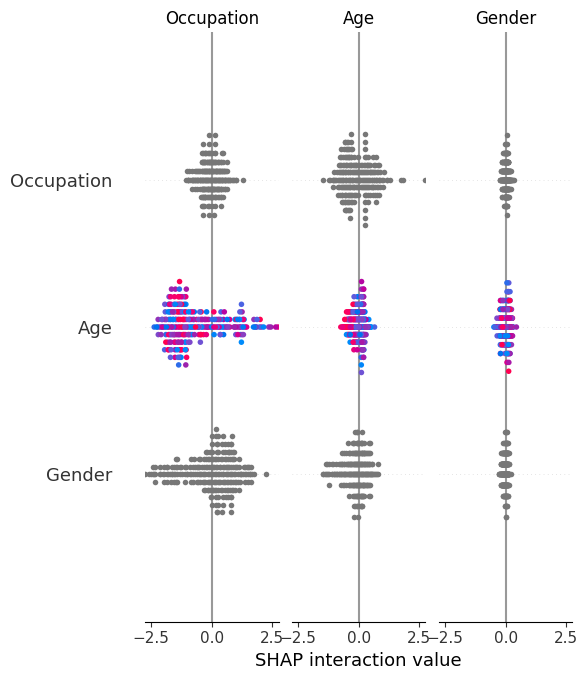

In [57]:
shap.summary_plot(shap_values, X_test)

-------------------------------------------------------------------------------------------------------------------------------------------

<h1 style="text-align: center;">Koniec rozdziału: Interpretacja rezultatów</h1>

<div style="display: flex; justify-content: center;">
  <div style="text-align: left; background-color: #f9f9f9; padding: 20px 30px; border-radius: 10px; border: 1px solid #ddd; width: fit-content; font-size: 16px; line-height: 1.8;">

<ol>
  <li><a href="#wprowadzenie">Wprowadzenie</a></li>
  <li><a href="#wczytywanie-danych">Wczytywanie danych</a></li>
  <li><a href="#feature-engineering-/-eda">Feature Engineering / EDA</a></li>
  <li><a href="#modelowanie">Modelowanie</a></li>
  <li><a href="#optymalizacja-hiperparametrów">Optymalizacja hiperparametrów</a></li>
  <li><a href="#interpretacja-rezultatów">Interptretacja rezultatów</a></li>
</ol>

  </div>
</div>

<p style="text-align: center; font-size: 14px; color: gray;">⬆️ Kliknij linki, aby przejść do wybranej sekcji</p>

-------------------------------------------------------------------------------------------------------------------------------------------